In [1]:
# ! pip install sklearn

In [2]:
# Batchsize = 1024, 5 epochs in 

In [6]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1_score

from tqdm.notebook import tqdm
from matplotlib.pyplot import figure

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [7]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr
def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [8]:
np.random.seed(42)

In [9]:
data_path = '/opt/recsys20_challenge/dataset/Training_2_M_Data.tsv'
columns   = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",
             "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",
             "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",
             "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",
             "engaging_user_account_creation", "engagee_follows_engager", "reply_timestamp", "retweet_timestamp", 
             "retweet_with_comment_timestamp", "like_timestamp"]

In [10]:
len(columns)

24

In [11]:
%%time
colnames = ["reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]
df = pd.read_csv(data_path, sep='\x01', encoding='utf-8', header=None, usecols=[20, 21, 22, 23], names=colnames)

CPU times: user 4.66 s, sys: 305 ms, total: 4.97 s
Wall time: 4.97 s


In [12]:
len(df)

2000000

In [13]:
df.head()

reply_timestamp  retweet_timestamp  retweet_with_comment_timestamp  \
0              NaN                NaN                             NaN   
1              NaN                NaN                             NaN   
2              NaN                NaN                             NaN   
3              NaN                NaN                             NaN   
4              NaN                NaN                             NaN   

   like_timestamp  
0             NaN  
1    1.581319e+09  
2    1.581406e+09  
3             NaN  
4    1.581516e+09

In [14]:
labels_df = pd.DataFrame(index=df.index, columns=['id', 'like', 'reply', 'retweet', 'quote'])

In [15]:
labels_df['id'] = df.index
labels_df['like'] = 1 - np.isnan(df.like_timestamp).astype(int)
labels_df['quote'] = 1 - np.isnan(df.retweet_with_comment_timestamp).astype(int)
labels_df['retweet'] = 1 - np.isnan(df.retweet_timestamp).astype(int)
labels_df['reply'] = 1 - np.isnan(df.reply_timestamp).astype(int)

In [16]:
labels_df.head()

id  like  reply  retweet  quote
0   0     0      0        0      0
1   1     1      0        0      0
2   2     1      0        0      0
3   3     0      0        0      0
4   4     1      0        0      0

In [17]:
labels_df.describe().loc['mean']

id         999999.500000
like            0.435668
reply           0.025943
retweet         0.110196
quote           0.007334
Name: mean, dtype: float64

In [18]:
plt# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = np.load(f'/opt/recsys20_challenge/bert_embeddings/train_2M/avg/{ID}_avg.npy')
        if np.sum(np.isnan(X)) > 0:  X = np.zeros(X.shape, X.dtype)
        X = torch.tensor(X)# .to('cuda')
        y = self.labels[ID]

        return X, y

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('device', device)
torch.backends.cudnn.benchmark = True

device cuda


In [28]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 8}

# Label to predict
col_to_id = {c:i for i,c in enumerate(labels_df)}
to_predict = 'reply'

# Datasets
list_IDs  = labels_df.values[:, 0]
labels    = labels_df.values[:, col_to_id[to_predict]]
oh_labels = np.eye(2)[labels].astype(int)

test_len = int(0.1*len(labels_df))
train_IDs, val_IDs = list_IDs[test_len:], list_IDs[:test_len]
train_test_split(list_IDs, test_size=0.1, random_state=42)
train_df = labels_df.iloc[train_IDs]

pos = list(train_df[train_df[to_predict] == 1].index)
neg = list(np.random.choice(train_df[train_df[to_predict] == 0].index, len(pos) * 2, replace=False))
train_IDs = pos + neg
partition = {'train': train_IDs, 'validation': val_IDs}

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

In [29]:
def find_nan_entries(df):
    nan_IDs = []
    for ID in list_IDs:
        X = np.load(f'/opt/recsys20_challenge/bert_embeddings/avg/{ID}_avg.npy')
        if np.sum(np.isnan(X)) > 0:
            nan_IDs.append(ID)
    return df.iloc[nan_IDs]

In [31]:
labels_df.iloc[train_IDs][to_predict].value_counts()

0    93492
1    46746
Name: reply, dtype: int64

In [32]:
# Training
for local_batch, local_labels in validation_generator:
    # Transfer to GPU
    print(local_batch.shape)
    print(local_labels.shape)
    print(local_batch[0][:10])
    break

torch.Size([256, 768])
torch.Size([256])
tensor([ 0.5159, -0.4263, -0.0231, -0.2395,  0.6731,  0.1486, -0.3173,  0.2915,
        -0.2852, -0.0650])


In [33]:
for local_batch, local_labels in training_generator:
    # Transfer to GPU
    print(local_batch.shape)
    print(local_labels.shape)
    # local_batch, local_labels = local_batch.to(device), local_labels.to(device)

    # Model computations
    # [...]
    break

# Validation
with torch.set_grad_enabled(False):
    for local_batch, local_labels in validation_generator:
        # Transfer to GPU
        print(local_batch.shape)
        print(local_labels.shape)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        # [...]
        break

torch.Size([256, 768])
torch.Size([256])
torch.Size([256, 768])
torch.Size([256])


# fc with CrossEntropyLoss

Following this example: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [34]:
def backprop(X, y, model, optimizer, loss_fn):
    # print(X[0][:10])
    # print(output.shape, y.shape)
    # print(output[0], y[0])

    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [35]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(42)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

        # extra layers layers
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim)

        
    def forward(self, x):
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)

        return logits

In [129]:
%%time

model_params = {'input_dim': 768,
                'hidden_dim': 10,
                'output_dim': 2}

ffnet     = FeedForwardNetwork(**model_params).to('cuda')

CPU times: user 0 ns, sys: 5.44 ms, total: 5.44 ms
Wall time: 3.8 ms


In [130]:
train_losses = {}
val_results  = {}

In [131]:
log_interval = 1000

In [132]:
learning_rate = 0.01 #3e-4

In [133]:
weights = np.power(labels_df.iloc[train_IDs][to_predict].value_counts().values, 2)
weights = max(weights) * 1 / weights
weights = torch.Tensor(weights).to('cuda')
weights

tensor([1.0000, 1.9190], device='cuda:0')

In [134]:
loss_fn   = nn.CrossEntropyLoss(weight=weights) 
optimizer = torch.optim.SGD(ffnet.parameters(), lr=learning_rate)#, momentum=0.9)

In [201]:
%%time
max_epochs = 1
for epoch in range(len(val_results), len(val_results) + max_epochs):
    # Training
    ffnet.train()
    print('Epoch', epoch)
    train_losses[epoch] = []

    for batch, (local_batch, local_labels) in enumerate(tqdm(training_generator)):
        # tranfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        l = backprop(local_batch, local_labels, ffnet, optimizer, loss_fn)
        train_losses[epoch].append(l)
        
        if batch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(local_batch), len(training_generator.dataset),
                100. * batch / len(training_generator), l))    
    print(f'Average loss on epoch {epoch}: {np.mean(train_losses[epoch])}')

    
    # Validation
    ffnet.eval()
    with torch.no_grad():
        val_results[epoch] = {'out':[], 'gt':[]}
        for local_batch, local_labels in tqdm(validation_generator):
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            logits_output = ffnet(local_batch) #.float()
            val_results[epoch]['out'].append(logits_output.cpu())
            val_results[epoch]['gt'].append(local_labels.cpu())
    
        all_out = [l for batch in val_results[epoch]['out'] for l in batch.numpy()]
        all_gt  = [l for batch in val_results[epoch]['gt'] for l in batch.numpy()]
        
        print('PRAUC:', compute_prauc(softmax(all_out)[:, 1], all_gt) * 100)
        print('RCE:', compute_rce(softmax(all_out)[:, 1], all_gt))

Epoch 46


Train Epoch: 46 [0/140238 (0%)]	Loss: 0.644198

Average loss on epoch 46: 0.6334269263230972



PRAUC: 6.029522699862379
RCE: -412.0312909618364
CPU times: user 5.03 s, sys: 1.57 s, total: 6.6 s
Wall time: 21.5 s


In [202]:
for epoch in train_losses:
    print(epoch, np.mean(train_losses[epoch]))

0 0.6786514501066974
1 0.6590039632181182
2 0.6527609832748009
3 0.6484674589477316
4 0.6460318009566216
5 0.6445912561059868
6 0.6434778277456326
7 0.6423206127037967
8 0.6419681360686782
9 0.6414259870121949
10 0.6408827407081632
11 0.6414303182467928
12 0.6406598253189212
13 0.6402386761929867
14 0.6404418343827672
15 0.6394855271290688
16 0.6388926812767113
17 0.6392915686116601
18 0.6382050622988792
19 0.6387242653074056
20 0.6385827362537384
21 0.6376561128745114
22 0.6377980065171736
23 0.6375189752039248
24 0.6374323750934462
25 0.6373758240990395
26 0.6371635246450884
27 0.6367461851043422
28 0.636812412064441
29 0.636337696418275
30 0.6356608361875924
31 0.6359991223490151
32 0.636196080024225
33 0.6355714808850392
34 0.635760550842668
35 0.6351059903628635
36 0.6347868784065664
37 0.6345725080175121
38 0.6344811023369322
39 0.6350394940941874
40 0.6338131706209948
41 0.6342882595575638
42 0.6335780230099267
43 0.6339648363799074
44 0.6332707985909316
45 0.6338392414533309
46

In [203]:
metrics = ['Accuracy', 'F1-score', 'PRAUC', 'RCE']
scores  = {m: [] for m in metrics}
scores_rand =  {m: [] for m in metrics}

for epoch in val_results:
    scores[epoch] = {}
    scores_rand[epoch] = {}
    
    all_out = [l for batch in val_results[epoch]['out'] for l in batch.numpy()]
    all_gt  = [l for batch in val_results[epoch]['gt'] for l in batch.numpy()]
    all_rand = np.random.rand(len(all_gt), 2)
    
    scores['Accuracy'].append(accuracy(np.argmax(all_out, axis=1), all_gt) * 100)
    scores['F1-score'].append(f1_score(np.argmax(all_out, axis=1), all_gt) * 100)
    scores['PRAUC'].append(compute_prauc(softmax(all_out)[:, 1], all_gt) * 100)
    scores['RCE'].append(compute_rce(softmax(all_out)[:, 1], all_gt))
    scores_rand['Accuracy'].append(accuracy(np.argmax(all_rand, axis=1), all_gt))
    scores_rand['F1-score'].append(f1_score(np.argmax(all_rand, axis=1), all_gt))
    scores_rand['PRAUC'].append(compute_prauc(softmax(all_rand)[:, 1], all_gt) * 100)
    scores_rand['RCE'].append(compute_rce(softmax(all_rand)[:, 1], all_gt) * 100)
    
    print('EPOCH', epoch)
    print('Accuracy', scores['Accuracy'][-1])
    print('F1-score', scores['F1-score'][-1])
    print('PRAUC', scores['PRAUC'][-1])
    print('RCE', scores['RCE'][-1])

EPOCH 0
Accuracy 60.6815
F1-score 7.571786222216999
PRAUC 4.257216452348292
RCE -464.46776543476574
EPOCH 1
Accuracy 64.8625
F1-score 8.193658797862751
PRAUC 4.721079168018311
RCE -436.9781535044876
EPOCH 2
Accuracy 68.572
F1-score 8.493230455670403
PRAUC 4.852800577963761
RCE -406.553042977621
EPOCH 3
Accuracy 68.946
F1-score 8.610947616244848
PRAUC 4.964510377850204
RCE -396.7649803095239
EPOCH 4
Accuracy 61.7175
F1-score 8.247150886191235
PRAUC 5.103623959876065
RCE -433.6802048330011
EPOCH 5
Accuracy 66.5215
F1-score 8.552424917029734
PRAUC 5.203598831945213
RCE -396.4956342459794
EPOCH 6
Accuracy 62.9105
F1-score 8.38139937009819
PRAUC 5.301486964042441
RCE -417.78610346507355
EPOCH 7
Accuracy 61.673500000000004
F1-score 8.341603989046861
PRAUC 5.378609429480418
RCE -422.9441741607366
EPOCH 8
Accuracy 58.9805
F1-score 8.156731038343128
PRAUC 5.419637202582449
RCE -441.62070735781026
EPOCH 9
Accuracy 63.751999999999995
F1-score 8.436900070728502
PRAUC 5.444963696678007
RCE -405.822

<Figure size 640x480 with 0 Axes>

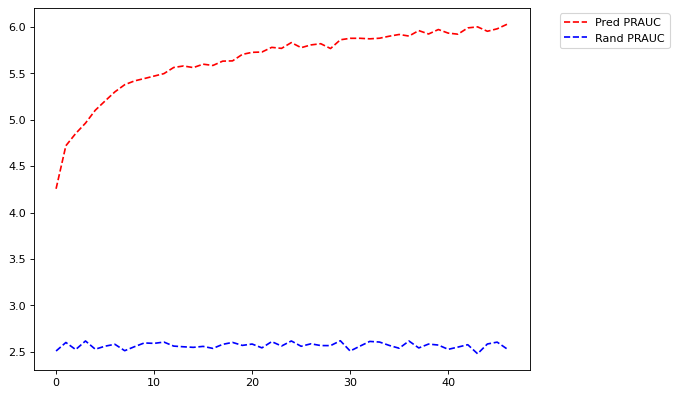

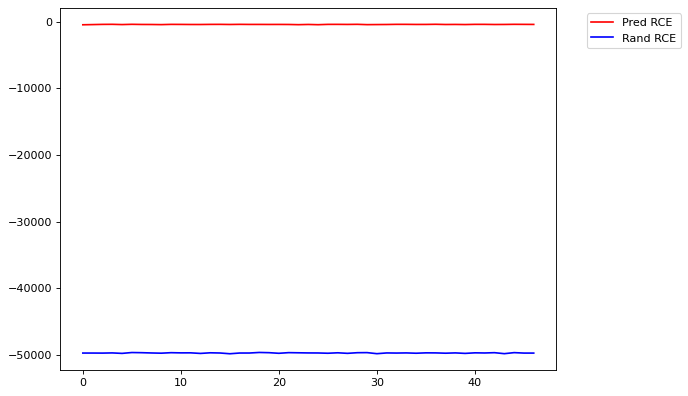

In [204]:
figure(figsize=(8, 6), dpi=80)

epochs = range(len(val_results))
figure(figsize=(8, 6), dpi=80)
# plt.plot(epochs, scores['Accuracy'],     'r^', label='Pred Acc')

# plt.plot(epochs, scores['F1-score'], 'r-', label='Pred F1')
# plt.plot(epochs, scores_rand['F1-score'], 'b-', label='Rand F1')
plt.plot(epochs, scores['PRAUC'], 'r--', label='Pred PRAUC')
plt.plot(epochs, scores_rand['PRAUC'], 'b--', label='Rand PRAUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

figure(figsize=(8, 6), dpi=80)

plt.plot(epochs, scores['RCE'], 'r-', label='Pred RCE')
plt.plot(epochs, scores_rand['RCE'],'b-', label='Rand RCE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [206]:
columns = ['id', 'no_'+to_predict+'_score', to_predict+'_score', 'no_'+to_predict+'_softmax', to_predict+'_softmax', to_predict+'_prediction', to_predict+'_gt']
df_out = pd.DataFrame(columns=columns)
df_out['id'] = val_IDs
df_out = df_out.set_index('id')

In [207]:
df_out.iloc[:, 0:2] = all_out
df_out.iloc[:, 2:4] = softmax(all_out)

In [208]:
df_out.iloc[:, 4] = np.argmax(all_out, axis=1)
df_out.iloc[:, 5] = all_gt

In [209]:
df_out.head()

no_reply_score reply_score no_reply_softmax reply_softmax  \
id                                                             
0        0.438911   -0.534156          0.72573       0.27427   
1       -0.032721    0.561255         0.355723      0.644277   
2       0.0354188    0.047056         0.497091      0.502909   
3        0.500428   -0.365373         0.703871      0.296129   
4        0.961983    -1.00756         0.877562      0.122438   

    reply_prediction  reply_gt  
id                              
0                  0         0  
1                  1         0  
2                  1         0  
3                  0         0  
4                  0         0

In [210]:
len(df_out)

200000

In [211]:
accuracy(df_out[to_predict+'_prediction'], df_out[to_predict+'_gt'])

0.625625

In [212]:
! mkdir predictions

mkdir: impossible de créer le répertoire « predictions »: Le fichier existe


In [213]:
df_out.to_csv('predictions/'+to_predict+'_2M.csv')

# Generating output for Eval Set

In [39]:
%%time
eval_df = pd.read_csv('/opt/recsys20_challenge/dataset/eval.tsv', sep='\x01', encoding='utf-8', header=None, 
                      names=["tweet_id", 'engaging_id'], usecols=[2, 14])

CPU times: user 32.7 s, sys: 1.93 s, total: 34.6 s
Wall time: 34.6 s


In [41]:
eval_df.head()

tweet_id                       engaging_id
0  7647B4E9DAF4C1D8973397DC2A04F3E3  0000006C3074607050F1339DDCB890BB
1  408DB1803264B5FF55F73EC06BE9BD77  000013315386492275CCBF7AEF293EF0
2  2EE951379C47E8BF62EABB8FA027F753  00001569CB28972FC8173122D9DA162F
3  2135F24B05DAE3EF213F9CE80FDC6DAF  00001607209C5774DF9207A2AC0EED5F
4  09143FEDE9BD494A6EA9A7EE160565E3  0000177705514C315F2FC6DFA3872712

In [42]:
eval_df.index

RangeIndex(start=0, stop=12791997, step=1)

In [43]:
class EvalDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = np.load(f'/opt/recsys20_challenge/bert_embeddings/eval/avg/{ID}_avg.npy')
        if np.sum(np.isnan(X)) > 0:  X = np.zeros(X.shape, X.dtype)
        X = torch.tensor(X)# .to('cuda')

        return X

In [44]:
eval_set = EvalDataset(eval_df.index, labels)
eval_generator = data.DataLoader(eval_set, batch_size=1)

In [45]:
for local_batch in eval_generator:
    # Transfer to GPU
    print(local_batch.shape)
    print(local_batch[0][:10])
    break

torch.Size([1, 768])
tensor([-0.2525, -0.6565,  0.6422,  0.2984,  0.6023,  0.1117,  0.4412, -0.0255,
         0.0016, -0.3660])


In [47]:
like_logits = []
like_scores = []
with torch.no_grad():
    for local_batch in tqdm(eval_generator):
        # Transfer to GPU
        local_batch = local_batch.to(device)
        logits_output = ffnet(local_batch) #.float()
        like_logits.append(logits_output.cpu())

In [48]:
labels_df = pd.DataFrame(index=df.index, columns=['id', 'like', 'reply', 'retweet', 'quote'])

In [92]:
like_logits

12791997